###### settings

In [8]:
!pip3 install xgboost

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier 

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer


from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [21]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

# 1. 결정트리 

## 1.1. 분류의 개요 
- 분류 문제 해결 모델
    - 베이지안 모델 : Naive Bayes
    - 독립변수/종속변수 선형 모델 : Logistic Regression 
    - 데이터 균일도에 따른 모델 : Decision Tree
    - 개별 클래스 간 최대 분류 마진이용 : Support Vector Machine
    - 군집화 기준 : Nearest Neighbor ( K-nearest )
    - 신경망 : Neural Network 
    - Ensemble 
- 앙상블 ( Ensemble ) : 정형 데이터 예측 분석에서 매우 높은 예측 성능 
        - 배깅
            - RandomForest 
            - Gradient Boosting
            - XgBoost(eXtra Gradient Boost) / LightGBM 
        - 부스팅 
        - Stacking 
- 결정트리 
    - 스케일링, 정규화 등의 사전 가공 영향이 적음
    - 복잡한 규칙 구조로 과접합
        - 앙상블처럼 여러 학습기를 결합하여 예측 성능 향상 가능 
       

## 1.2 결정트리와 정보의 균일도 ( 지니계수와 Information Gain )
### 정보의 균일도 측정 
    - Gini 계수 ( 결정 트리의 기준 ), 낮을 수록 잘 분류된 것 
$$G_i = 1-\sum_{i=1}^n({p_i,_k})^2 $$
$${p_i,_k} = i^{th} node에서,      \frac{i^{th} node에서 k클래스에 속하는원소  }{i^{th} node에 속하는 총 원소  } $$
    - Entropy와 Information Gain
        - Information Gain = 상위 노드의 Entropy - 현재 노드의 Entropy 
        - 클수록 속성 A로 분류하기 좋은 것임을 의미 
$$ H_i = -\sum_{k=1}^n{p_i,_k}\log_2({p_i,_k}) $$
$$ IG(A속성, S) = H(S)-\sum_{k=1}^n{p_i,_k}\log_2({p_i,_k}) $$ 

### 결정 트리 모델의 특징 
- Regressio과 Classification 사용 가능 
- 대부분의 경우에서 각 피처의 스케일링과 전처리 작업이 필요 없음 
- 과접합이 생기기 쉽다
    - 하이퍼파라미터들의 설정이 필요 !!
    
### 결정트리 파라미터 ( DecisionTreeClassifier / DecisionTreeRegressor 메소드 ) 
- 과적합 제어 파라미터
    - min_samples_split : 노드 분할을 위한 최소 샘플 데이터 / default = 2
    - min_samples_leaf : 말단 노드가 되기 위한 최소한의 샘플 데이터 수 
        - 비대칭적 데이터일 경우 특정 클래스 값이 매우 작을 수 있으므로 작게 설정 
    - max_features : 최적의 분할을 위해 고려할 최대 피처의 갯수
        - sqrt : $\sqrt{전체 피처 개수}$ 
        - log : $\log{전체 피처 개수}$
    - max_depth : 트리 최대 깊이 설정 
    - max_leaf_nodes : 최대 말단 노드 개수 

## 1.3. 결정 트리 시각화 및 하이퍼파라미터( max_depth & min_samples_leaf )
from sklearn.tree import export_graphviz   
export_graphviz(dt_clf, out_file="저장 파일 이름", class_names= "클래스명", feature_names"= "데이터 컬럼명"
    - class_names= "분류할 클래스명" : 결정 트리에서 Categorize 되는 이름들
    - feature_names"= "가져올 데이터 컬럼명" : 입력될 데이터에서 사용될 컬럼 이름들 


### 1.3.1. 하이퍼파라미터 설정에 따른 정확도 및 트리 모양 
- DecisionTreeClassifier()
- DecisionTreeClassifier(max_depth = 3)
- DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 6)

###### (1) 아무런 설정을 하지 않았을 경우 

In [94]:

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)
    
# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)

# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)

# DecisionTreeClassifier 예츨 
pred = dt_clf.predict(X_test)

print('Default 정확도 : ', accuracy_score(y_test, pred))

Default 정확도 :  0.9333333333333333


In [95]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names , \
feature_names = iris_data.feature_names, impurity=True, filled=True)

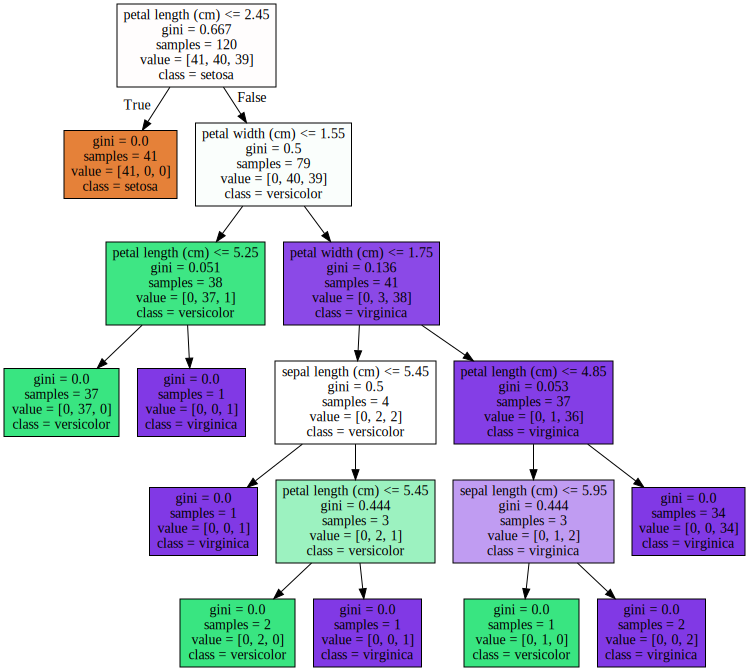

In [96]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

###### (2) DecisionTreeClassifier(max_depth = 3)

In [97]:
# DecisionTree Classifier 생성 
# max_depth = 3
dt_clf = DecisionTreeClassifier(random_state=156, max_depth = 3)
    
# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)
# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)

# 예측 
pred = dt_clf.predict(X_test)

print('max_dept = 3 정확도 : ', accuracy_score(y_test, pred))

max_dept = 3 정확도 :  0.9333333333333333


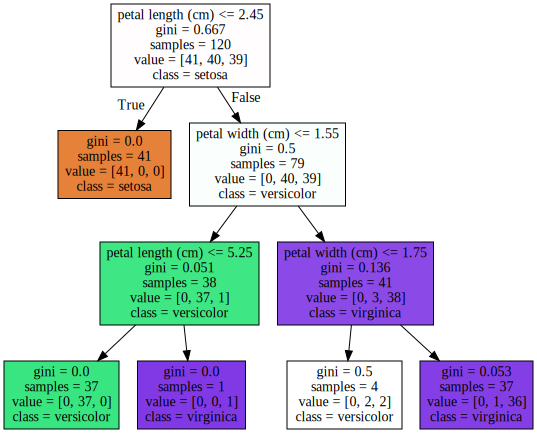

In [98]:
from sklearn.tree import export_graphviz 

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함.
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names , \
feature_names = iris_data.feature_names, impurity=True, filled=True)

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
# graphviz.Source(dot_graph)names = iris_data.feature_names, impurity=True, filled=True)

import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()

    # 그래프 그리기 
graphviz.Source(dot_graph)

In [99]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
# graphviz.Source(dot_graph)

###### (3) DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 6)

In [100]:
# DecisionTree Classifier 생성 
# max_depth = 3
dt_clf = DecisionTreeClassifier(random_state=156, max_depth = 3, min_samples_leaf = 6)
    
# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)
# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)

# 예측 
pred = dt_clf.predict(X_test)

print('max_dept = 3 정확도 : ', accuracy_score(y_test, pred))

max_dept = 3 정확도 :  0.8666666666666667


In [101]:
from sklearn.tree import export_graphviz 

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함.
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names , \
feature_names = iris_data.feature_names, impurity=True, filled=True)

In [102]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()

    # 그래프 그리기 
# graphviz.Source(dot_graph)

### 1.3.2. 결정트리 알고리즘 학습 규칙 : feature_importance 속성
- dt_clf.feature_importances_ 
    -  각 Decision Tree의 중요 역할 지표를 중요도 순으로 가져옴 

Feature importances:
[0.    0.    0.566 0.434]
sepal length (cm) : 0.000
sepal width (cm) : 0.000
petal length (cm) : 0.566
petal width (cm) : 0.434


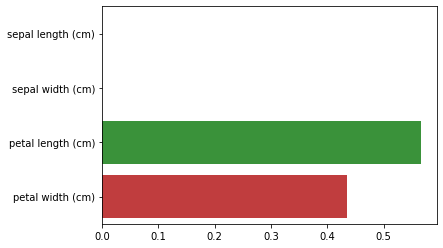

In [103]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(iris_data.feature_names , dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=dt_clf.feature_importances_ , y=iris_data.feature_names)

# 2. 앙상블

## 2.1 앙상블 개요 
<img src='./img/04_보팅_배깅.jpg' width = '80%' height = '80%' > 
### 앙상블 학습 유형
#### ( 1 ) 보팅(Voting) : 
- 서로 다른 알고리즘을 가진 분류기를 결합, 여러개의 분류기가 투표를 통해 최종 예측 결과 결정
- 하드 보팅 : 다수의 classifier 간 다수결로 최종 class 결정
- 소프트 보팅 : 다수의 classifier 들의 class 확률을 평균하여 결정
    - 일반적으로 소프트 보팅 사용  
<img src='./img/04_하드_소프트_보팅.jpg' width = '90%' height = '90%' align = 'left' >  

 
  
#### ( 2 ) 배깅(Bagging) : Random Forest  
- 같은 유형의 알고리즘을 가진 분류기를 결합, 부트스트래핑을 통한 샘플링
- 대부분, 베이스 분류기는 Decision Tree 알고리즘 

#### ( 3 ) 부스팅(Boosting) : Adaboost, GBM, XGB, LGBM
- 여러 개의 분류기가 순차적으로 학습, 각 분류기가 예측이 틀린 데이터에 대해 가중치(weight)를 부여하며 학습  
- 대부분, 베이스 분류기는 Decision Tree 알고리즘 

#### ( 4 )스태깅
- 여러 가지 다른 모델의 예측 결팟값을 다시 학습 데이터로 만들어서 다른 모델(메타 모델)로 재학습시켜 결과를예측
    

## 2.1 앙상블 ( 보팅 ) 
- sklearn.ensemble import VotingClassifier
- 데이터의 특성에 따라, 기반 분류기(base) 중 가장 좋은 분류기의 성능이, 보팅했을 때 보다 나은 결과가 나올 수 있음 

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import load_breast_cancer

In [105]:
# load dataset 
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


###### KNN과 Logistic Regression 분류기를 사용한  " 소프트 보팅 "

In [106]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR', lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)

print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


## 2.2 앙상블 ( 배깅 ) - Random Forest 
- sklearn.ensembel import RandomForestClassifier 
- 장점
    - "" 변수가 굉장히 굉장히 많은 "" 데이터 학습에 용이
- 단점 
    - 하이퍼 파라미터 튜닝을 위한 시간이 오래 걸림 
    - 시간에 비해 성능이 크게 향상이 되지 않음 
<img src='./img/04_랜덤포레스트.jpg' width = '90%' height = '90%' align = 'left' >

- 대부분, 베이스 분류기는 Decision Tree 알고리즘
- 개별 베이스 Decision Tree는 여러 개의 데이터세트를 주업되게 분리하여 샘플링 수행
    - Random Forest의 서브세트 데이터는 부트스트랩을 통해 임의의 데이터 사용 
<img src='./img/04_부트스트램.jpg' width = '100%' height = '100%' align = 'left' >  

- 하이퍼 파라미터 : n_estimators = 3, 원본 데이터 = 10개 >인 경우 부트스트랩

### 2.2.1. 랜덤포레스트 ( RandomForestClassifier ) 
- from sklearn.ensemble import RandomForestClassiher
- 속도를 원하는 경우 

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


### 2.2.2. 랜덤포테스트 하이퍼 파라미터 및 튜닝 ( GridSearchCV )
- from sklearn.model_selection import GridSearchCV
- 하이퍼 파라미터 ( 결정트리와 같음 )
    - n_estimators':[100],
    - max_depth' : [6, 8, 10, 12], 
    - min_samples_leaf' : [8, 12, 18 ],
    - min_samples_split' : [8, 16, 20]

###### 하이퍼파라미터 튜닝 
- 최적 하이퍼파라미터 튜닝값 
    - max_depth : 10 -> "Base 트리들의 깊이"
    - min_samples_leaf : 8
    - n_estimators : 100 
- 하이퍼파라미터 튜닝해서 나온 classifier 가져오기
best_ft_clf = grid_cv.best_estimator_

In [108]:
from sklearn.model_selection import GridSearchCV

params1 = {
    'n_estimators':[100],
    # 100, 300, 500 넣어서 최적의 파라미터를 갖는 r_clf 가져오기 
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

params2 = {
    'n_estimators':[200],
    # 100, 300, 500 넣어서 최적의 파라미터를 갖는 r_clf 가져오기 
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

params3 = {
    'n_estimators':[300],
    # 100, 300, 500 넣어서 최적의 파라미터를 갖는 r_clf 가져오기 
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# n_jobs = -1 : 멀티코어에서 병렬 처리


rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

grid_cv1 = GridSearchCV(rf_clf , param_grid=params1 , cv=2, n_jobs=-1 )
grid_cv1.fit(X_train , y_train)

grid_cv2 = GridSearchCV(rf_clf , param_grid=params2 , cv=2, n_jobs=-1 )
grid_cv2.fit(X_train , y_train)

grid_cv3 = GridSearchCV(rf_clf , param_grid=params3 , cv=2, n_jobs=-1 )
grid_cv3.fit(X_train , y_train)

print('1 최적 하이퍼 파라미터:\n', grid_cv1.best_params_)
print('1 최고 예측 정확도: {0:.4f}'.format(grid_cv1.best_score_))
print('2 최적 하이퍼 파라미터:\n', grid_cv2.best_params_)
print('2 최고 예측 정확도: {0:.4f}'.format(grid_cv2.best_score_))
print('3 최적 하이퍼 파라미터:\n', grid_cv3.best_params_)
print('3 최고 예측 정확도: {0:.4f}'.format(grid_cv3.best_score_))

# 

1 최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
1 최고 예측 정확도: 0.9180
2 최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200}
2 최고 예측 정확도: 0.9151
3 최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}
3 최고 예측 정확도: 0.9144


###### 튜닝된 하이퍼 파라미터를 갖는 예측기로 재 학습 후 예측 / 평가

In [109]:
rf_clf1 = grid_cv1.best_estimator_
rf_clf2 = grid_cv2.best_estimator_
rf_clf3 = grid_cv3.best_estimator_


rf_clf1.fit(X_train , y_train)
pred1 = rf_clf1.predict(X_test)
print('n-estimator = 100, 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred1)))

rf_clf2.fit(X_train , y_train)
pred2 = rf_clf2.predict(X_test)
print('n-estimator = 300, 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred2)))

rf_clf3.fit(X_train , y_train)
pred3 = rf_clf3.predict(X_test)
print('n-estimator = 500, 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred3)))

n-estimator = 100, 예측 정확도: 0.9196
n-estimator = 300, 예측 정확도: 0.9186
n-estimator = 500, 예측 정확도: 0.9165


###### 중요 결정 Feature 데이터 시각화 ( RF_Classifier.feature_importances_ )
- ( dt_clf / rf_clf ).feature_importances_ 
    -  각 Decision Tree의 중요 역할 지표를 중요도 순으로 가져옴 

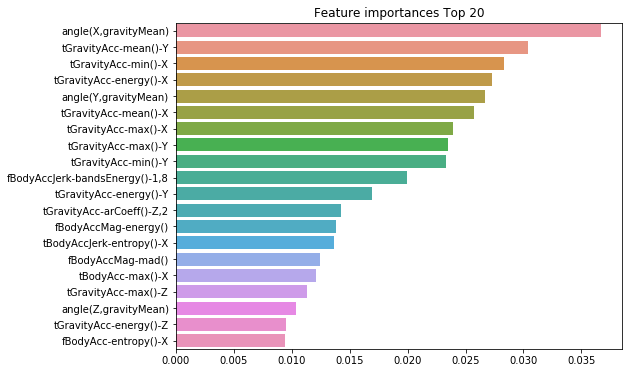

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## 2.3. 앙상블 ( 부스팅 ) 
##### AdaBoost와  GBM ( Gradient Boosting Machine ) 
- 여러 개의 약한 학습기(Weak Learner)를 순차적으로 학습-예측, 잘못 예측한 데이터에 가중치 부여, 오류 개선 
- 병렬 처리가 되지 않기때문에 속도 느리다 
- 좀 더 정확한 에측이 가능 

- 종류 :
    - (1) AdaBoost
    - (2) GDM 
    - (3) 기본 스태킹 
    - (4) CV 기반 스태킹 

### 2.3.1. AdaBoost ( 에이다부스트 )
- 오류 데이터에 가중치 부여 
<img src = './img/04_에이다부스팅.jpg' height = '80%' width = '80%' >

#### AdaBoost 예측 과정 

##### ( 1 ) j번째 예측기의 에러율 계산 
- 각각의 요소들의 가중치 ${w}^{(i)}$ 는 ${{1}\over{m}}$으로 나누어짐

- i번예 예측기들의 error_rate = $ {r}_{i} $
<img src = './img/04_에이다_에러.jpg' height = '80%' width = '80%' >

##### ( 2) 잘못된 feature에 대한 가중치 계산

- 각각의 학습 후의 "잘못 분류된 feature"들에 대한 예측 확률에는 가중치들이 부여가 됨 
- 정확한 예측기일 수록, 이 요소들에 대한 가중치(weight) $ {\alpha_j} $는 커짐
    - 무작위로 연산할 경우, 이 weight = 0으로 수렴

$$ {\alpha_j} = {{\eta}log{{(1-{r}_j)}}\over{r_j}} $$

##### (3 )이 후, instance weight update, boosting the weights of the __misclassified instances__
- 아래의 식을 통해, 각 분류 확률이 업데이트가 되고, 각 분류 예측 확률은 
    - $\sum_{i=1}^m\omega^{i}$로 나누어지어 정규화시킴 
<img src = './img/04_가중치_계싼.jpg' height = '40%' width = '40%' >


###### (4) 각각의 예측기들의 예측 확률은 (1) ~ (3) 번 방식이 원하는 예측기들의 수에 도달할 때까지 반복이 되어 연산

###### (5) 최종 예측 확률 연산 
- (1) ~ (4)까지 연산을 통해 , 각각의 예측기들의 예측 확률을 계산하고 각각의 예측기들이 갖고 있는 각각의 클래스들이 갖고있는 weight ( $ {\alpha_j} $ )의 중요도를 연산
- 이 후 예측 되는 class 들은 가장 가중치가 많이 적용된 예측기의 예측 확률을 따름. ( 아래 식 참고 )

<img src = './img/04_에이다_최종연산.jpg' width = '60%' height = '60%'>

### 2.3.2. Gradient Boost Machine( GBM, 그래디언트 부스트 )
- from sklearn.ensemble import GradientBoostingClassifier

###### 하이퍼 파라미터 
- loss : 겅사 하강법에서 사용할 비용 함수 ( Default : deviance ) 
- learning_rate : 매 학습시(예측기 -> 예측기) 적용하는 학습률 
    - ( Default = 0.1 )
    - 작은 값을 입력할수록 예측 성능 향상 
    - 너무 작은 값을 입력하면, 시간이 오래 걸리고, 최소 오류 값을 찾지 못할 수 있음 
- Learning Rate <-> n_estimator 상호작용 
    - Learning Rate 낮게, n_estimator 높게 ....
- n_estimators : weak learner의 갯수
    - 많을 수록 "일정 성능"까지 높아짐 
    - 많은 수록 시간이 오래 걸림 
    - ( Default = 100 )
- subsample : base learning가 학습에 사용하는 데이터의 샘플링 비율 
    - 0.5일 경우 전체 데이터의 50%만 학습 데이터로 사용
    - 과적합 컨트롤 가능 ( -> 1 보다 작게 설정 )

- 다음 예측기는 이전 예측기의 잔차 에러에 fit하게 만들면서 classification error 개선
    - 경사 하강법 사용 ( Gradient Descent )
        - 회귀에서 학습 !!!!!!!

######  GBM 수행 시간 측정 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForest 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import time 

X_train, X_test, y_train, y_test = get_human_dataset()


# 시작 시간 
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

rf_clf = RandomForest()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print('GBM 정확도 : {0:4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0:.1f}초'.format(time.time() - start_time))

print('RF 정확도 : ',format(rf_accuracy))
print('RF 수행 시간 : {0:.1f}초'.format(time.time() - start_time))

###### GMB 하이퍼 파라미터 및 튜닝 
- 병렬 처리가 안됨!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1] #
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1, n_jobs = -1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score',
'split0_test_score', 'split1_test_score']]

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

### 2.3.3. XGBOOST : https://lsjsj92.tistory.com/547
- from xgboost import XGBClassifier, plot_importanceㄹㄹ
- 장점 
    - gbm보다는 빠름
    - 과적합 방지할 수 있도록 규제 파라미터 있음
    - CART 기반 -> 분류 / 회귀 가능 
    - 조기 종료 
    - 부스팅을 기반으로, 즉 경사하강법을 통해 학습시킨다
- 단점
    - lightgbm이 더 빠름 

- 설치
    - pip install xgboost 


<img src = './img/04_XGB.jpg' height = '50%' width = '50%' >

###### 하이퍼 파라미터 
- n_estimators : 베이스 결정 트리 갯수 
- learning_rate : 학습 가중치 
- max_depth : 트리 max_depth 
- subsample : 데이터 샘플링 비율 ( 0 ~ 1)
- random_state=1
- reg_lambda : L2 규제
- reg_alpha : L1 rbwp

- fit
    - early_stopping_rounds

In [17]:
from xgboost import XGBClassifier, plot_importance

In [6]:
params = {
    'n_estimators':[3],
    'max_depth' : [2], 
    'subsample' : [0.3],
    'learning_rate' : [0.1]
}

xgb_clf = XGBClassifier()

grid_cv1 = GridSearchCV(xgb_clf , param_grid=params , cv=2, n_jobs=-1, scoring = 'accuracy' )
grid_cv1.fit(X_train, y_train)
print( grid_cv1.best_params_ )
print( grid_cv1.best_score_ )

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 3, 'subsample': 0.3}
0.8263057671381937


In [14]:
best_xgb = grid_cv1.best_estimator_
pred = best_xgb.predict(X_test)
accuracy_score(y_test,pred)

0.7885985748218527

In [15]:
xgb_clf.fit(X_train, y_train)
xgb_clf.predict(X_test)

array([5, 5, 5, ..., 2, 2, 2])

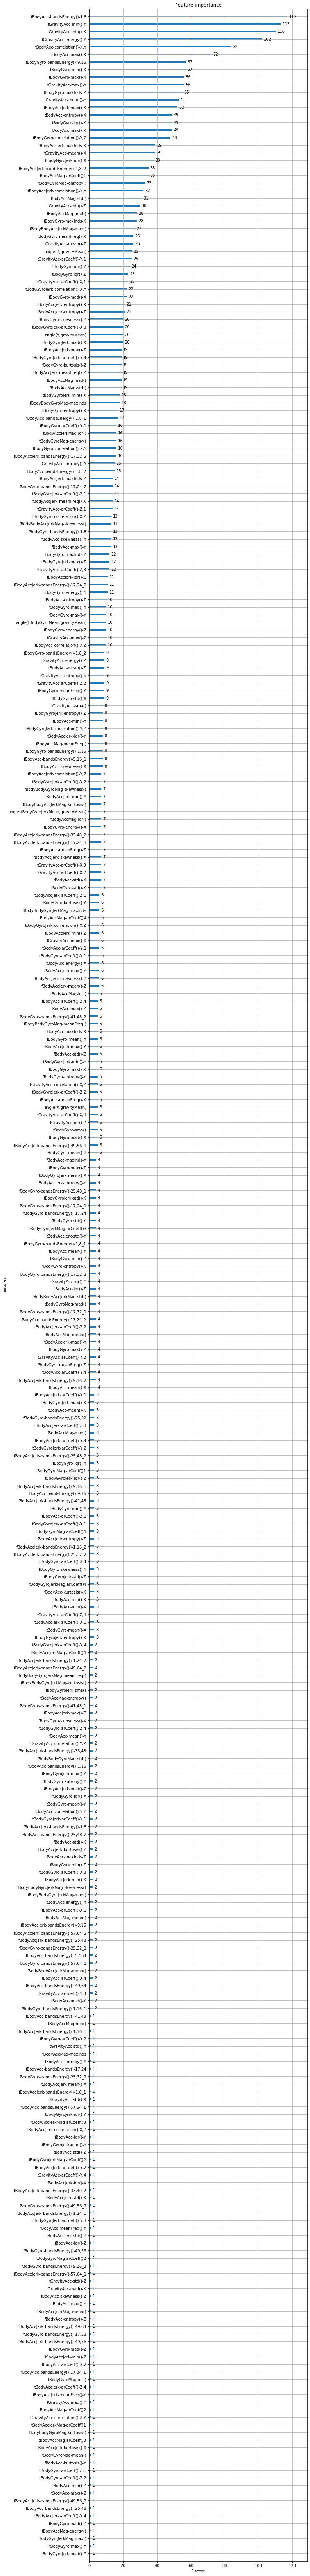

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 120))
plot_importance(xgb_clf, ax=ax)

### 2.3.4. LGBM
pip install lightgbm   
from lightgbm import LGBMClassifier, plot_importance  
- 하이퍼파라미터 
    - n_estimators : 반복하려는 트리의 개수
    - learning_rate : 학습률
    - max_depth : 트리의 최대 깊이
    - min_child_samples : 리프 노드가 되기 위한 최소한의 샘플 데이터 수
    - num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수
    - feature_fraction : 트리를 학습할 때마다 선택하는 feature의 비율
    - reg_lambda : L2 regularization
    - reg_alpha : L1 regularization

기존 boosting 모델들은 트리를 level-wise하게 늘어나는 방법을 사용했는데요.   
lightgbm은 leaf wise(리프 중심) 트리 분할을 사용합니다.   
level-wise 트리 분석은 균형을 잡아주어야 하기 때문에 tree의 depth가 줄어듭니다.   
그 대신 그 균형을 잡아주기 위한 연산이 추가되는 것이 단점이죠.   

lightgbm은 트리의 균형은 맞추지 않고 리프 노드를 지속적으로 분할하면서 진행합니다.   
그리고 이 리프 노드를 max delta loss 값을 가지는 리프 노드를 계속 분할해갑니다.   
그렇기 때문에 비대칭적이고 깊은 트리가 생성되지만 동일한 leaf를 생성할 때   
leaf-wise는 level-wise보다 손실을 줄일 수 있다는 것이 장점입니다.  

<img src='./img/04_LGBM.jpg'>

In [ ]:
!pip install lightgbm

In [19]:
from lightgbm import LGBMClassifier, plot_importance

params = {
    'n_estimators':[3],
    'max_depth' : [2], 
    'subsample' : [0.3],
    'learning_rate' : [0.1]
}

lgb_clf = LGBMClassifier()

grid_cv1 = GridSearchCV(lgb_clf , param_grid=params , cv=2, n_jobs=-1, scoring = 'accuracy' )
grid_cv1.fit(X_train, y_train)
print( grid_cv1.best_params_ )
print( grid_cv1.best_score_ )

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 3, 'subsample': 0.3}
0.7916213275299238


In [20]:
best_lgb = grid_cv1.best_estimator_
pred = best_lgb.predict(X_test)
accuracy_score(y_test,pred)

0.7953851374278927

In [25]:
lgb_clf.fit(X_train, y_train)
lgb_clf.predict(X_test)

array([5, 5, 5, ..., 2, 2, 2])

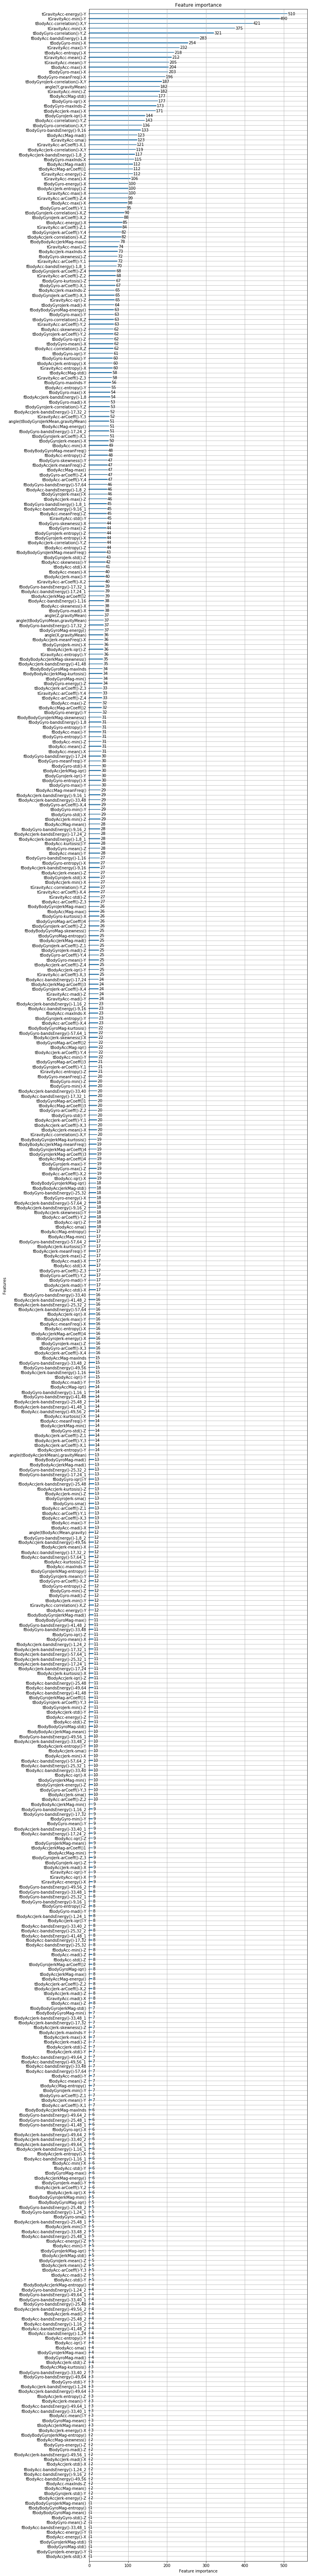

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 120))
plot_importance(lgb_clf, ax=ax)

# 스태킹 앙상블

## 기본 스태킹 앙상블 
- 참고 : https://lsjsj92.tistory.com/558?category=853217  

### 기본 스태킹 학습 방법 
1. 개별 모델들에 training data 학습
2. 각 학습된 모델에 test data 이용하여 예측 ( 3개의 predictions ) 
3. 3개의 prediction을 학습 데이터로 사용 
4. 최종 모델을 선정하여 학습 

<img src = './img/04_스태킹 앙상블.jpg' >

In [32]:
data = load_breast_cancer() 

X_data = data.data 
y_data = data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


###### 스태킹에 사용할 개별 모델 로드
- 개별 모델 : Decision Tree / Logistic Regression / Random Forest 
- 최종 모델 : LGBMC

In [48]:
# 스태킹에 사용할 모델 
dt_clf = DecisionTreeClassifier(max_depth = 10)
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 10)
lr_clf = LogisticRegression()

# 최종 모델 
lgb_clf = LGBMClassifier() 

###### 개별 모델 학습, 예측

In [49]:
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)

dt_pred = dt_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###### 개별 모델 예측 데이터로 새로운 데이터 빌딩  (  (n행) x (개별 모델 수 열)  )

In [61]:
new_data = np.array([dt_pred, rf_pred, lr_pred])
new_data = new_data.transpose()

###### 최종학습 

In [67]:
lgb_clf.fit(new_data, y_test)
lgb_pred = lgb_clf.predict(new_data)
accuracy_score(y_test, lgb_pred)

0.9473684210526315

## CV 기반 스태킹
- 참고 : https://lsjsj92.tistory.com/559?category=853217

### CV 기반 스태킹 학습 방법 
1. 데이터를 Fold로 나눔 
2. 각 모델 별로 Fold로 나누어진 데이터로 모델 훈련, 검증 데이터, 테스트 

In [34]:
from sklearn.model_selection import KFold 
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
#         print(folder_counter , (train_index, valid_index))
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        print(train_index, valid_index, sep = '\n')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [35]:
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(max_depth = 5)
dt_clf = DecisionTreeClassifier(max_depth = 5)
lgb_clf = LGBMClassifier()

data = load_breast_cancer() 

X_data = data.data 
y_data = data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)  

lgb_train, ada_test = get_stacking_base_datasets(lgb_clf, X_train, y_train, X_test, 7)

(455, 30) (455,)
(114, 30) (114,)
KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 

	 폴드 세트:  1  시작 
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 3

DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298


	 폴드 세트:  4  시작 
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

### SMOTE 오버샘플링 